In [126]:
import pandas as pd
import numpy as np
from pathlib import Path
from definitions import ROOT_DIR
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc, rc_context
import matplotlib
from anndata import AnnData
from seriate import seriate
import scanpy as sc
from scipy.spatial.distance import pdist
# from plotnine import *
import re

matplotlib.rcParams['pdf.fonttype'] = 42
rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':12})

#Returns list of hard-coded paths (to avoid repetition in multiple function definitions)
def paths():
    p_root_dir = Path(ROOT_DIR).parents[0]
    p_data = p_root_dir / "data"
    p_out = p_root_dir / "test"

    # Compounds name and ID information
    p_compounds = p_data / "compounds_ids.csv"

    # Compound mapping to wells
    p_wellmap = p_data / "wellmap.csv"

    # Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
    p_datasets = p_data / "Datasets_18Jan2023.csv"

    # Classification
    p_chem_class = p_data / "custom_classification_v2.csv"
    p_pathways = p_data / "pathways_v2.csv"
    p_predictions = p_data / "2022-08-16_All_Interlab_Predictions.csv"

    paths = {
            'p_root_dir' : p_root_dir,
            'p_data' : p_data,
            'p_out' : p_out,
            'p_compounds' : p_compounds,
            'p_wellmap' : p_wellmap,
            'p_datasets' : p_datasets,
            'p_chem_class' : p_chem_class,
            'p_pathways' : p_pathways,
            'p_predictions' : p_predictions
    }
    return paths

#Format ion formulas to publication standard
def pretty_ion_formulas(adnl, pol=""):
    
    adnl = [string.replace("[M]-","") for string in adnl]
    adnl = [string.replace("[M]+","") for string in adnl]
    adnl = [string.replace("++","+") for string in adnl]
    adnl = [string.replace("--","-") for string in adnl]
    adnl = [re.sub('([0-9])', '$_\\1$', string) for string in adnl]
    adnl = ['[M'+string+']' for string in adnl]
    if pol == 'Pos':
        adnl = [string+'$^+$' for string in adnl]
    elif pol == 'Neg':
        adnl = [string+'$^-$' for string in adnl]
    return adnl

#Calculate and store peaks normalized to sum of peaks per molecule
def calculate_signal_composition(df):
    addlist = []
    
    for sample in list(set(df['sample_name'])): #For each dataset (one polarity, full range)
        
        for molecule in list(set(df[df['sample_name']==sample]['name_short'])): #For each unique named molecule
            
            #Sum up intensities of all matching adduct/neutral loss peaks and store
            molsum = sum(df[(df['sample_name']==sample) & (df['name_short']==molecule)]['spot_intensity_bgr_corrected'])
            addlist.append({'sample_name':sample, 'name_short':molecule, 'molsum':molsum})
    
    #Add sum intensity information to main dataframe
    addf = pd.DataFrame(addlist)
    newdf = pd.merge(df, addf, left_on=['sample_name','name_short'], right_on=['sample_name','name_short'], how='left')
    
    #Calculate the signal contribution of each row as intensity divided by total intensity
    newdf['frac'] = newdf['spot_intensity_bgr_corrected']/newdf['molsum']
    return newdf

#Load csv files and organize dataframe
def prepare_df(paths):

    #Load predictions
    predictions = pd.read_csv(paths['p_predictions'], index_col=0)
    predictions.neutral_loss.fillna('', inplace=True)

    #Load metadata files
    compounds = pd.read_csv(paths['p_compounds'], index_col='internal_id')
    wellmap = pd.read_csv(paths['p_wellmap'], index_col='internal_id')
    chem_class = pd.read_csv(paths['p_chem_class'], index_col='internal_id')
    pathways = pd.read_csv(paths['p_pathways'], index_col='internal_id')
    datasets = pd.read_csv(paths['p_datasets'])
    
    #Load class data. WARNING: risk of duplication
    main_chem_class = chem_class[['name_short', 'main_coarse_class']].drop_duplicates()

    # Get a subset of most relevant information from Datasets file and add a unique sample name to each merged dataset (full mass range, single polarity)
    datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Participant lab', 'Slide code', 'All', 'EMBL', 'Interlab', 'Technology', 'Matrix short']] # 'Participant lab', 'Technology'
    datasets_info['sample_name'] = datasets_info['Slide code'] + ': ' + datasets_info['Technology'] + ': ' + datasets_info['Matrix short']

    # Merge with predictions
    df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')
    df.sort_values(by = ['adduct', 'neutral_loss'], inplace=True)
    
    #Format adduct/neutral loss to output-ready format
    df['neutral_loss'] = df['neutral_loss'].apply(lambda x: x if len(x) < 7 else '+Matrix')
    df['adduct_and_nl'] = pretty_ion_formulas(df.adduct+df.neutral_loss)
    df['Polarity'] = [('Pos' if x=='positive' else 'Neg') for x in df['Polarity']] 
    
    #Remove duplicates
#    df['problems'] = df['sample_name'] + "  " + df['Polarity'] + ", molecule: " + df['name_short'] + df['adduct_and_nl']
#    df.sort_values(by='pred_val', ascending=False)
#    df['dupemask']=df.duplicated(subset='problems', keep='first')
#    df = df[~df.dupemask].drop(['dupemask','problems'], axis='columns')
#    df = df.sort_index()
    
    #Merge in metadata, apply filters
    df = df[df['neutral_loss'] != '+HCl']
    df = df.merge(main_chem_class, on='name_short', how='left')
    df = df[df['Interlab']]
#     df = df[df['pred_threestate']==2]
    df = calculate_signal_composition(df)
    df = df.drop_duplicates(subset=['sample_name','name_short','adduct_and_nl'])
    
    return df

def filter_neutral_losses(df, filter_on=True, neutral_losses_to_keep=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    '''
    if filter_on==True:
        df = df[df.neutral_loss.isin(neutral_losses_to_keep)]
    elif filter_on == 'only_nl':
        df = df[df.neutral_loss != '']
    return df

def calculate_detected_intensities(df):
    '''
    Make a column with background corrected intensities for detected compounds, and 0s for not detected compounds
    Change any negative values to zero
    '''
    intensities_for_twostate_spots = (df.pred_twostate == 1) * df.spot_intensity_bgr_corrected
    df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
    intensities_for_threestate_spots = (df.pred_threestate == 2) * df.spot_intensity_bgr_corrected
    df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
    return df

def filter_polarity(df, polarity):
    '''
    Filter out entries based on polarity pol ['pos', 'neg']
    '''
    return df[df['Polarity'] == polarity]

def group_by_molecule(df, intensity_col_name, prediction_col_name):
    '''
    Aggregate intensity and detection values per class
    '''
    
    if intensity_col_name == 'val_threestate':
        intensity_aggregation_func = lambda x: (x==2).any()
    else: intensity_aggregation_func = lambda x: (x==1).any()
            
    
    data = df.pivot_table(index=['name_short'],
                          columns=['sample_name'],
                          values=[intensity_col_name, prediction_col_name],
                          aggfunc = {
                                intensity_col_name : lambda x: np.log10(sum(x)+1),
                                prediction_col_name : intensity_aggregation_func
                          },
                          fill_value=0)
    data = data.stack(level=1, dropna=False).reset_index()
    # If no ions on a molecule were detected by matrix, prediction column contains fill value 0 instead of False, correct for that:
    data.loc[data[prediction_col_name] == 0, prediction_col_name] = False
    return data

def prep_molecule_data(data, polarity,  intensity_col_name, prediction_col_name, nl_filter_on=False, neutral_losses_to_keep=None):
    '''
    '''
    data = filter_neutral_losses(data, nl_filter_on, neutral_losses_to_keep)
    data = calculate_detected_intensities(data)
    data = filter_polarity(data, polarity)
    data = group_by_molecule(data, intensity_col_name, prediction_col_name)
    
    return data

def summarise_per_fine_class(df, fine_class_col_name, coarse_class_col_name, intensity_col_name, prediction_col_name):
    
    df['class_size'] =1
    data = df.pivot_table(index=['sample_name'],
                                   columns=[fine_class_col_name, coarse_class_col_name],
                                   values=[intensity_col_name, prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum,
                                        intensity_col_name : np.mean
                                   },
                                   fill_value=0)
    
    data = data.stack(level=[1,2], dropna=True).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']    
    
    # sort columns alphabetically
    data = data.sort_values(by='sample_name')
    # sort rows first by coarse class, then by fine class
    data = data.sort_values(by=[coarse_class_col_name, fine_class_col_name])
    return data

def summarise_per_coarse_class(df, class_col_name, intensity_col_name, prediction_col_name):
    
    df['class_size'] = 1
    data = df.pivot_table(index=['sample_name'],
                                   columns=class_col_name,
                                   values=[intensity_col_name, prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum,
                                        intensity_col_name : np.mean
                                   },
                                   fill_value=0)
    
    data = data.stack(level=1, dropna=False).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']
    
    
    # sort columns alphabetically
    data = data.sort_values(by='sample_name')    
    return data

In [127]:
df = prepare_df(paths())

In [128]:
pol = "Pos"

In [129]:
molecule_data

,name_short,sample_name,pred_threestate,val_threestate
0,2-Oxoglutaric acid,10I: MALDI-FTICR: DHB,False,0.000000
1,2-Oxoglutaric acid,12C: MALDI-FTICR: DHB,True,4.821658
2,2-Oxoglutaric acid,12G: MALDI-qTOF: DHB,True,2.171645
3,2-Oxoglutaric acid,13G: MALDI-qTOF: DHB,True,2.029302
4,2-Oxoglutaric acid,14B: AP-MALDI-Orbitrap: SDHB,False,0.000000
...,...,...,...,...
2101,myo-Inositol,4F: MALDI2-Orbitrap: DHAP,True,4.500084
2102,myo-Inositol,5HJ: DESI-Orbitrap: none,True,3.876814
2103,myo-Inositol,7J: AP-MALDI-Orbitrap: DHB,True,3.207916
2104,myo-Inositol,8A: AP-MALDI-Orbitrap: DHB,True,3.368362


In [130]:
# Map chemical classes
chem_class = pd.read_csv(paths()['p_chem_class'], index_col='internal_id')
chem_class = chem_class[['name_short', 'main_coarse_class']].drop_duplicates()
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

class_data = summarise_per_coarse_class(mapped_data,
                                            class_col_name='main_coarse_class',
                                            intensity_col_name= 'val_threestate',
                                            prediction_col_name = 'pred_threestate')


In [137]:
mapped_data.to_csv(r"D:\saharuka\spotting\spotting_git\interlaboratory_comparison\test\his_mapped_data.csv")

In [134]:
plot_data = class_data.pivot_table(index = ['sample_name'],
                                       columns=['main_coarse_class'],
                                       values=['fraction_detected'],
                                       aggfunc = {
                                            'fraction_detected':sum,
                                       },
                                       fill_value=0).T
plot_data = plot_data.reindex(columns=plot_data.columns[seriate(pdist(plot_data.T.to_numpy()))])

In [135]:
plot_data

sample_name                                                7J: AP-MALDI-Orbitrap: DHB  \
                  main_coarse_class                                                     
fraction_detected Amines                                                     1.000000   
                  Amino acids, peptides, and analogues                       0.977778   
                  Carbohydrates                                              0.687500   
                  Carboxylic acids                                           0.866667   
                  Lipids and lipid-like molecules                            0.914286   
                  Nucleosides, nucleotides, and analogues                    0.875000   
                  Vitamins and cofactors                                     1.000000   

sample_name                                                9A: IR-MALDESI-Orbitrap: water  \
                  main_coarse_class                                                         
fraction_detected Amines                                                         1.000000   
                  Amino acids, peptides, and analogues                           0.977778   
                  Carbohydrates                                                  1.000000   
                  Carboxylic acids                                               0.800000   
                  Lipids and lipid-like molecules                                0.828571   
                  Nucleosides, nucleotides, and analogues                        0.958333   
                  Vitamins and cofactors                                         0.875000   

sample_name                                                8A: AP-MALDI-Orbitrap: DHB  \
                  main_coarse_class                                                     
fraction_detected Amines                                                     1.000000   
                  Amino acids, peptides, and analogues                       0.911111   
                  Carbohydrates                                              0.937500   
                  Carboxylic acids                                           0.600000   
                  Lipids and lipid-like molecules                            0.742857   
                  Nucleosides, nucleotides, and analogues                    0.958333   
                  Vitamins and cofactors                                     1.000000   

sample_name                                                12C: MALDI-FTICR: DHB  \
                  main_coarse_class                                                
fraction_detected Amines                                                1.000000   
                  Amino acids, peptides, and analogues                  0.933333   
                  Carbohydrates                                         1.000000   
                  Carboxylic acids                                      0.600000   
                  Lipids and lipid-like molecules                       0.914286   
                  Nucleosides, nucleotides, and analogues               0.916667   
                  Vitamins and cofactors                                0.937500   

sample_name                                                4F: MALDI2-Orbitrap: DHAP  \
                  main_coarse_class                                                    
fraction_detected Amines                                                    1.000000   
                  Amino acids, peptides, and analogues                      0.977778   
                  Carbohydrates                                             1.000000   
                  Carboxylic acids                                          0.600000   
                  Lipids and lipid-like molecules                           0.971429   
                  Nucleosides, nucleotides, and analogues                   0.833333   
                  Vitamins and cofactors                                    0.937500   

sample_n

# Interlab heatmaps

In [ ]:
for pol in ['Pos', 'Neg']:
    molecule_data = prep_molecule_data(df,
                                       polarity=pol, 
                                       nl_filter_on=True, 
                                       neutral_losses_to_keep=[''], 
                                       intensity_col_name= 'val_threestate',
                                       prediction_col_name = 'pred_threestate')

    # Map chemical classes
    chem_class = pd.read_csv(paths()['p_chem_class'], index_col='internal_id')
    mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

    class_data = summarise_per_coarse_class(mapped_data,
                                                class_col_name='main_coarse_class',
                                                intensity_col_name= 'val_threestate',
                                                prediction_col_name = 'pred_threestate')


    plot_data = class_data.pivot_table(index = ['sample_name'],
                                           columns=['main_coarse_class'],
                                           values=['fraction_detected'],
                                           aggfunc = {
                                                'fraction_detected':sum,
                                           },
                                           fill_value=0).T
    plot_data = plot_data.reindex(columns=plot_data.columns[seriate(pdist(plot_data.T.to_numpy()))])

    plot_data.to_csv(paths()['p_data'] / f'Plot_Data_{pol}.csv')
    
    plt.figure(figsize=[12,8])
    sns.heatmap(data=plot_data, 
                    yticklabels=plot_data.index.get_level_values(1), 
                    cmap='viridis',
                    cbar_kws={'label': 'Fraction Detected'}
                   )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title(f"{pol}")
    plt.xlabel("")
    plt.ylabel("")
    #plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(paths()['p_out'] / f"Heatmap_{pol}.pdf")

# PCA

In [3]:
def get_class_size(metadata, class_column):
    sizes = metadata[class_column].value_counts()
    metadata['class_size'] = [sizes[k] for k in metadata[class_column]]
    return metadata


def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df


def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df


def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df


def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
    return data


def group_by_molecule(df, groupby_columns):
    '''
    Aggregate intensity and detection values per groupby columns
    '''          
    data = df.groupby(groupby_columns).agg({
        'detectability' : 'max', # here detectability of metabolite is set to 1 if any of it's ions was detected
        'property1' : 'sum', # here the additional property is summed across all detected ions of metabolite
        'property2' : 'sum', # here the additional property is summed across all detected ions of metabolite
        'property3' : 'sum' # here the additional property is summed across all detected ions of metabolite
    }).reset_index()
    return data


def summarise_per_class(df, groupby_columns):
    
    data = df.groupby(groupby_columns).agg({'detectability' : 'sum', # here number of detected metabolites per class is counted
                                            'my_property' : 'mean', # here you take a mean of some property among all detected metabolites in that class
                                            'class_size': 'first'
                                            }).reset_index()

    data['fraction_detected'] = data.detectability / data['class_size'] 
    data.drop(columns=['detectability', 'class_size'], inplace=True)
    return data


def assemble_adata(pca):
    observables = pca.index.to_frame(index=False)
    for col in observables.columns:
        observables[col] = observables[col].astype('category')  
    variables = pca.columns.to_frame(index=False)
    adata = AnnData(pca.values, obs=observables, var=variables)
    return adata

In [ ]:
# p_root_dir = Path(ROOT_DIR).parents[0]
# p_data = p_root_dir / "5_data_analysis"
# p_out = p_root_dir / "6_plots" / "Interlab"

# # Metrics and Catboost predictions for all ions in their target wells
# p_predictions = p_data / "2022-08-16_All_Interlab_Predictions.csv"

# # Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
# p_datasets = p_data / "Datasets_14Jul2022.csv"

# # Classification
# p_chem_class = p_data / "custom_classification_v2.csv"

In [25]:
# # Format neutral loss column, keep other columns that you need
# predictions = pd.read_csv(p_predictions, index_col=0)


# predictions.neutral_loss.fillna('', inplace=True)

# # Add dataset metadata 
# datasets = pd.read_csv(p_datasets)
metadata_columns = [
#     'Dataset name', 
                    'Participant lab', 
                    'Technology', 
#                     'Original technology', 
#                     'Ionisation source',
#                     'Mass analyser', 
#                     'Source pressure',
                    'Matrix short',
                    'Polarity', 
                    'Slide code',
                    'Interlab', 
                    'All'
                   ]
# datasets_info = datasets.groupby('Dataset ID').first()[metadata_columns]

# # Merge with predictions
# df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

# # Filter to keep only interlab datasets + EMBL datasets with 10ppm
# df = df[df['Interlab']] 
# only consider data of detected ions
threshold = 0.8
df['detectability'] = df.pred_val >= threshold
data = df[df.detectability]

In [30]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
                            polarity='Pos', 
                            neutral_losses=['']
                           )

# Add property that you want to use for PCA
filtered_data['property1'] = filtered_data['on_off_ratio'] * 1 # this is just an example that does nothing to the column, but you can do whatever
filtered_data['property2'] = filtered_data['spot_intensity_bgr_corrected_tic_norm'] * 1
filtered_data['property3'] = filtered_data['bg_intensity_tic'] * 1

# Summarise data per metabolite and dataset
molecule_data = group_by_molecule(filtered_data, groupby_columns=np.append(metadata_columns, 'name_short').tolist())

# Reshape
pca = molecule_data.pivot_table(values=['detectability'], # you can choose one or more of propeties for pca, the one I sent you is only using detectability 
                                 index=metadata_columns, 
                                 columns='name_short',
                                 fill_value=0)

In [32]:
# Assemble adata
adata = assemble_adata(pca)

# Apply Z-score normalisation: If you use only detectability for PCA, this is not needed
sc.pp.scale(adata, zero_center=True) 

# Compute PCA
sc.tl.pca(adata, svd_solver='arpack')

C:\Users\saharuka\AppData\Local\Temp\ipykernel_25988\98761730.py:78: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(pca.values, obs=observables, var=variables)
C:\Users\saharuka\.conda\envs\batch\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


C:\Users\saharuka\.conda\envs\batch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
meta NOT subset; don't know how to subset; dropped


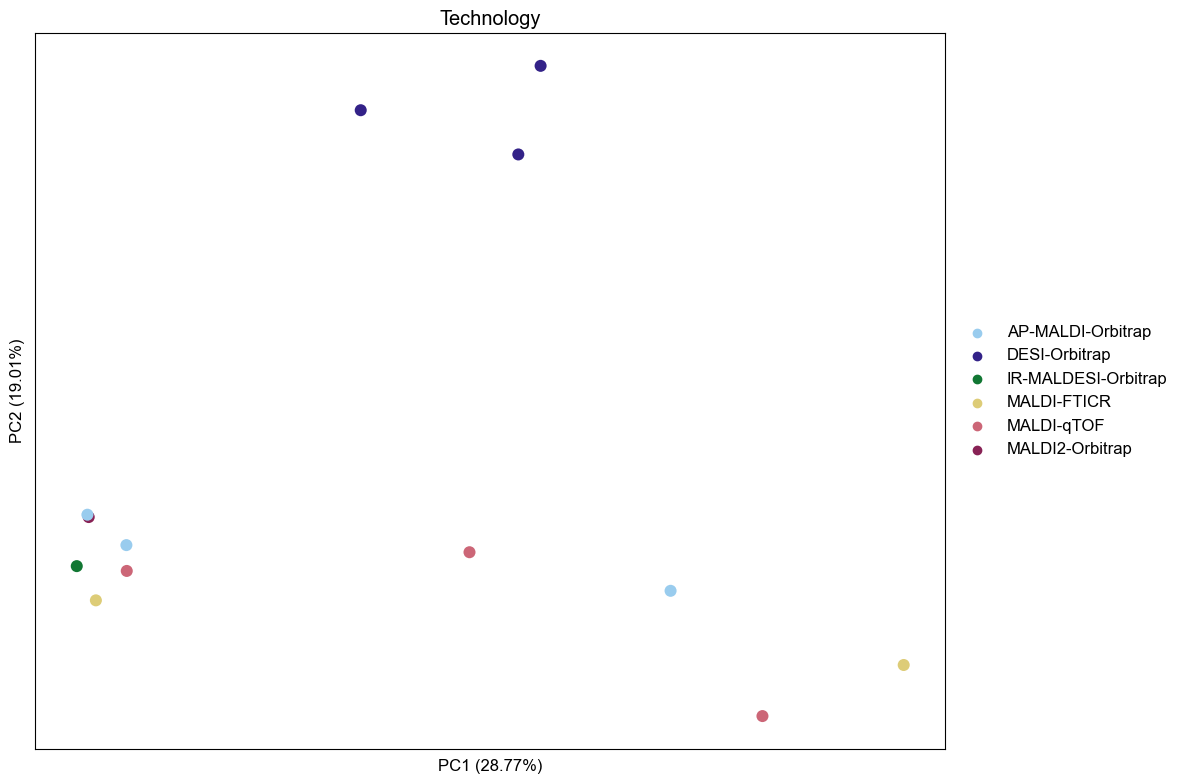

In [33]:
# Make plots
fname = "PCA_interlab_neg"

with rc_context():
    plt.rcParams["figure.figsize"] = (12,8)
    ax = sc.pl.pca(adata, 
                   components=['1, 2'], 
                   color=[
#                    'Dataset name', 
#                    'Participant lab', 
                    'Technology', 
#                    'Original technology', 
#                    'Ionisation source',
#                    'Mass analyser', 
#                    'Source pressure',
#                    'Matrix short',
#                    'Polarity', 
                   ],
                   palette = {
                    'DESI-Orbitrap' : '#332288',
                    'AP-MALDI-Orbitrap' : '#99CCEE',
                    'IR-MALDESI-Orbitrap' : '#117733',
                    'MALDI-FTICR' : '#DDCC77',
                    'MALDI-qTOF' : '#CC6677',
                    'MALDI2-Orbitrap' : '#882255',
                    }, 
                   size=300,
                   ncols=1, # Number of columns to organise subplots in
                   #legend_loc='left_edge',
                   show=False, 
                   #wspace=0.95,
                   annotate_var_explained = True
                  )
    plt.tight_layout()
plt.savefig(paths()['p_out'] / f"{fname}.pdf")
#     plt.savefig(p_out/ f"{fname}.png")
    